In [1]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


You should consider upgrading via the 'C:\Users\55319\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install stable-baselines3[extra] protobuf==3.20.*

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446679 sha256=95083d9a49bd98778531043d77e8c2fce4b13c759e6d9fee28d61573acba7b58
  Stored in directory: c:\users\55319\appdata\local\pip\cache\wheels\6b\1b\ef\a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


You should consider upgrading via the 'C:\Users\55319\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install mss pydirectinput pytesseract

You should consider upgrading via the 'C:\Users\55319\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [282]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

In [3]:
SCREEN_HEIGHT = 600
SCREEN_WIDTH = 1100

In [310]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,166,200), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 170, 'width': 500, 'height': 500}
        self.done_location = {'top': 550, 'left': 1050, 'width': 450, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0:'up',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, False, info
        
    
    def reset(self, seed=0):
        time.sleep(1)
        #pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation(), {}
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (200, 166))  # ou (300, 250), por exemplo
        channel = np.reshape(resized, (1, 166, 200))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['Your']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [311]:
env = WebGame()

In [219]:
obs=env.get_observation()
obs[0]

array([[ 15,  15,  15, ..., 255, 255, 255],
       [ 15,  15,  15, ..., 255, 255, 255],
       [ 15,  15,  15, ..., 255, 255, 255],
       ...,
       [ 15,  15,  15, ..., 255, 255, 255],
       [ 15,  15,  15, ..., 255, 255, 255],
       [ 15,  15,  15, ..., 255, 255, 255]], dtype=uint8)

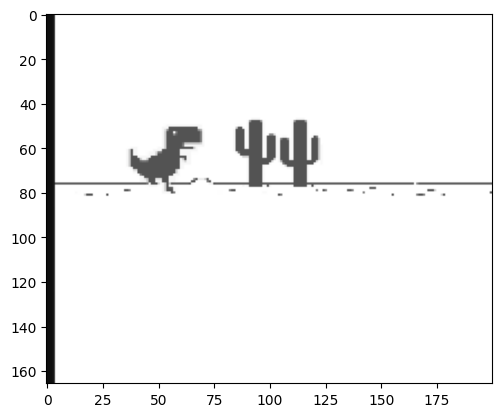

In [220]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [231]:
done, done_cap = env.get_done()

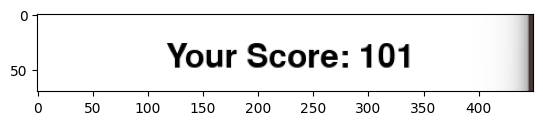

In [232]:
plt.imshow(done_cap)

In [233]:
pytesseract.image_to_string(done_cap)[:4]

'Your'

In [234]:
done

True

In [247]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done:  
        obs, reward,  done, truncated, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))     

Total Reward for episode 0 is 31
Total Reward for episode 1 is 10
Total Reward for episode 2 is 17
Total Reward for episode 3 is 9
Total Reward for episode 4 is 14
Total Reward for episode 5 is 10
Total Reward for episode 6 is 8
Total Reward for episode 7 is 19
Total Reward for episode 8 is 8
Total Reward for episode 9 is 9


In [248]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [312]:
env_checker.check_env(env)

In [313]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [314]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [315]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [316]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [317]:
env = WebGame()


In [320]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=12000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [322]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/DQN_2


KeyboardInterrupt: 